Прогнозирование вероятности выпадения осадков на следующий день (RainTomorrow) в Австралии.

In [1]:
# ==========================================
# ШАГ 0: Импорт библиотек и настройки
# (Step 0: Import libraries and settings)
# ==========================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings

# Настройка отображения (Display settings)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore') # Игнорировать предупреждения

print("✅ Шаг 0: Библиотеки успешно импортированы.")

✅ Шаг 0: Библиотеки успешно импортированы.


In [2]:
# ==========================================
# ШАГ 1: Загрузка, EDA (на сырых данных) и Очистка
# (Step 1: Load, Raw EDA, and Cleaning)
# ==========================================
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split

filename = "weatherAUS.csv"

if os.path.exists(filename):
    print("🔄 1. Загрузка данных (Loading Raw Data)...")
    raw_df = pd.read_csv(filename)
    
    # ---------------------------------------------------------
    # A. Печать исходной статистики(Print Raw Stats)
    # ---------------------------------------------------------
    print(f"   -> Размер (Size): {raw_df.shape}")
    target = 'RainTomorrow'
    print(f"   -> Пропуски в таргете (NaN in Target): {raw_df[target].isna().sum()}")

    # ---------------------------------------------------------
    # B. Удаление строк без таргета (Drop rows without Target)
    # (Это единственная очистка ДО отчета, так как без таргета анализ бессмыслен)
    # ---------------------------------------------------------
    df = raw_df.dropna(subset=[target]).copy()
    print(f"   -> Размер после удаления NaN в таргете: {df.shape}")

    # ---------------------------------------------------------
    # C. Разделение на Train/Test (СЫРЫЕ ДАННЫЕ)
    # (Split into Raw Train/Test)
    # ---------------------------------------------------------
    print("\n✂️ 2. Разделение на Train/Test (до очистки)...")
    # Используем stratify, чтобы сохранить баланс классов
    train_raw, test_raw = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
    
    # ---------------------------------------------------------
    # D. Генерация отчета ydata-profiling (НА СЫРЫХ ДАННЫХ)
    # (Generate Report on RAW Data - To see Missing & Extreme values)
    # ---------------------------------------------------------
    print("\n📊 3. Генерация отчета EDA (report_train_raw.html)...")
    print("   (Здесь мы увидим пропуски и выбросы, как требует задание)")
    
    # Генерируем отчет только для Train, чтобы сэкономить время (или для всего, если хотите)
    profile = ProfileReport(train_raw, title="EDA - Raw Training Data", minimal=True)
    profile.to_file("report_train_raw.html")
    print("✅ Отчет.txt сохранен! Откройте 'report_train_raw.html' чтобы увидеть пропуски.")

    # ---------------------------------------------------------
    # E. Очистка данных (Cleaning Data)
    # (Теперь чистим данные для моделей)
    # ---------------------------------------------------------
    print("\n🧹 4. Очистка данных (Cleaning)...")

    def clean_data(data):
        d = data.copy()
        # 1. Date processing
        if 'Date' in d.columns:
            d['Date'] = pd.to_datetime(d['Date'])
            d['Year'] = d['Date'].dt.year
            d['Month'] = d['Date'].dt.month
            d['Day'] = d['Date'].dt.day
            d = d.drop(columns=['Date'])
        
        # 2. Fill Missing Values (Imputation)
        # Numeric -> Median
        num_cols = d.select_dtypes(include=[np.number]).columns
        for col in num_cols:
            d[col] = d[col].fillna(d[col].median())
            
        # Categorical -> Mode
        cat_cols = d.select_dtypes(include=['object']).columns
        for col in cat_cols:
            if d[col].isna().sum() > 0:
                d[col] = d[col].fillna(d[col].mode()[0])
        
        return d

    # Применяем функцию очистки
    train_cleaned = clean_data(train_raw)
    test_cleaned = clean_data(test_raw)

    # ---------------------------------------------------------
    # F. Сохранение (Saving)
    # ---------------------------------------------------------
    print("\n💾 5. Сохранение очищенных данных...")
    train_cleaned.to_csv("train_cleaned.csv", index=False)
    test_cleaned.to_csv("test_cleaned.csv", index=False)
    print("✅ Готово! Файлы 'train_cleaned.csv' и 'test_cleaned.csv' созданы.")

else:
    print(f"❌ Ошибка: Файл {filename} не найден.")

🔄 1. Загрузка данных (Loading Raw Data)...
   -> Размер (Size): (145460, 23)
   -> Пропуски в таргете (NaN in Target): 3267
   -> Размер после удаления NaN в таргете: (142193, 23)

✂️ 2. Разделение на Train/Test (до очистки)...

📊 3. Генерация отчета EDA (report_train_raw.html)...
   (Здесь мы увидим пропуски и выбросы, как требует задание)


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 132.74it/s]


✅ Отчет.txt сохранен! Откройте 'report_train_raw.html' чтобы увидеть пропуски.

🧹 4. Очистка данных (Cleaning)...

💾 5. Сохранение очищенных данных...
✅ Готово! Файлы 'train_cleaned.csv' и 'test_cleaned.csv' созданы.


In [3]:
# ==========================================
# ШАГ 2: Генерация отчета EDA
# (Step 2: Generate EDA Report using ydata-profiling)
# ==========================================

# Загружаем только что созданные файлы
train_df = pd.read_csv("train_cleaned.csv")
test_df = pd.read_csv("test_cleaned.csv")

print("📊 Генерация отчетов EDA (это может занять несколько минут)...")

# 1. Отчет.txt для Train (основной)
# (Generating report for Train data)
print("   -> Создание отчета для Train...")
profile_train = ProfileReport(
    train_df, 
    title="EDA Report - Train Data", 
    minimal=True # 'minimal=True' ускоряет процесс
)
profile_train.to_file("report_train.html")

# 2. Отчет.txt для Test
# (Generating report for Test data)
print("   -> Создание отчета для Test...")
profile_test = ProfileReport(
    test_df, 
    title="EDA Report - Test Data", 
    minimal=True
)
profile_test.to_file("report_test.html")

print("\n✅ Готово! Отчеты 'report_train.html' и 'report_test.html' созданы.")
print("   (Проверьте файлы в меню слева)")

📊 Генерация отчетов EDA (это может занять несколько минут)...
   -> Создание отчета для Train...


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 165.84it/s]


   -> Создание отчета для Test...


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 61.70it/s]


✅ Готово! Отчеты 'report_train.html' и 'report_test.html' созданы.
   (Проверьте файлы в меню слева)


In [4]:
# ==========================================
# ШАГ 3: Подготовка данных и Кодирование признаков
# (Step 3: Data Preparation & Feature Encoding)
# ==========================================


import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, StandardScaler

print("🔄 [Шаг 3] Чтение данных...")
# Читаем уже очищенные данные из Шага 1
train_df = pd.read_csv("train_cleaned.csv")
test_df = pd.read_csv("test_cleaned.csv")

target_col = 'RainTomorrow'

# 1. Преобразование целевой переменной в числа (0/1)
# (Convert Target 'Yes'/'No' to 0/1)
if train_df[target_col].dtype == 'object':
    print("   -> Кодирование таргета (Target Encoding)...")
    le = LabelEncoder()
    train_df[target_col] = le.fit_transform(train_df[target_col])
    test_df[target_col] = le.transform(test_df[target_col])

# Разделение на признаки (X) и цель (y)
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

# Список категориальных колонок
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"📝 Категориальные признаки: {categorical_cols}")

print("\n⚙️ Применение кодировщиков (Applying Encoders)...")

# 2. WoE Encoding (для линейных моделей)
# (Weight of Evidence for Logistic Regression)
woe_encoder = ce.WOEEncoder(cols=categorical_cols)
X_train_woe = woe_encoder.fit_transform(X_train, y_train)
X_test_woe = woe_encoder.transform(X_test)

# 3. Target Encoding (для деревьев решений)
# (Target Encoding for Trees: RF, XGBoost)
te_encoder = ce.TargetEncoder(cols=categorical_cols)
X_train_te = te_encoder.fit_transform(X_train, y_train)
X_test_te = te_encoder.transform(X_test)

# 4. Стандартизация (только для Логистической регрессии)
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_woe)
X_test_lr = scaler.transform(X_test_woe)

print("✅ Шаг 3 выполнен: Данные закодированы и готовы к обучению.")

🔄 [Шаг 3] Чтение данных...
   -> Кодирование таргета (Target Encoding)...
📝 Категориальные признаки: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

⚙️ Применение кодировщиков (Applying Encoders)...
✅ Шаг 3 выполнен: Данные закодированы и готовы к обучению.


In [5]:
# ==========================================
# ШАГ 4: Обучение моделей
# (Step 4: Training Models)
# ==========================================

# Импорт моделей
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

print("🔥 [Шаг 4] Начало обучения моделей...")

# Словарь для сохранения предсказаний (чтобы использовать в Шаге 5)
predictions = {}

# --- Модель 1: Logistic Regression ---
print("\n1️⃣ Обучение Logistic Regression (на WoE данных)...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_lr, y_train)
# Сохраняем вероятности класса 1
predictions['Logistic Regression'] = lr_model.predict_proba(X_test_lr)[:, 1]

# --- Модель 2: Random Forest ---
print("\n2️⃣ Обучение Random Forest (на TargetEnc данных)...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
rf_model.fit(X_train_te, y_train)
predictions['Random Forest'] = rf_model.predict_proba(X_test_te)[:, 1]

# --- Модель 3: XGBoost ---
print("\n3️⃣ Обучение XGBoost (на TargetEnc данных)...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_te, y_train)
predictions['XGBoost'] = xgb_model.predict_proba(X_test_te)[:, 1]

# --- Модель 4: LightAutoML ---
print("\n4️⃣ Обучение LightAutoML (на исходном DataFrame)...")
task = Task('binary')
roles = {'target': target_col}

# Используем параметры без явного CV, чтобы избежать ошибок
automl = TabularAutoML(
    task=task, 
    timeout=300,       # 5 минут лимит
    cpu_limit=-1, 
    reader_params={'n_jobs': 1, 'random_state': 42}
)

# Обучаем на train_df (LAMA сама внутри себя делит на валидацию)
oof_pred = automl.fit_predict(train_df, roles=roles, verbose=0)
test_pred = automl.predict(test_df)
predictions['LightAutoML'] = test_pred.data[:, 0]

print("\n✅ Шаг 4 выполнен: Все 4 модели обучены, предсказания сохранены.")

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
🔥 [Шаг 4] Начало обучения моделей...

1️⃣ Обучение Logistic Regression (на WoE данных)...

2️⃣ Обучение Random Forest (на TargetEnc данных)...

3️⃣ Обучение XGBoost (на TargetEnc данных)...

4️⃣ Обучение LightAutoML (на исходном DataFrame)...

✅ Шаг 4 выполнен: Все 4 модели обучены, предсказания сохранены.


📈 [Шаг 5] Построение графиков...
   -> Logistic Regression: AUC=0.8668
   -> Random Forest: AUC=0.8739
   -> XGBoost: AUC=0.8976
   -> LightAutoML: AUC=0.8956

✅ ГРАФИК ГОТОВ! Сохранен как 'roc_curve_final_submission.png'


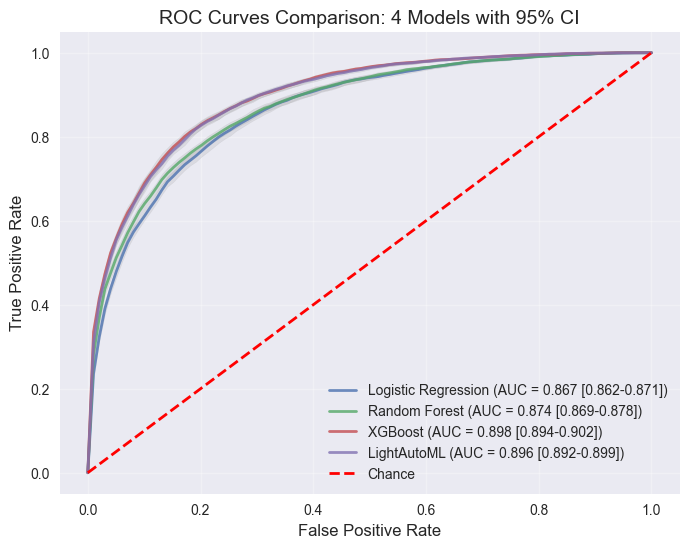

In [6]:
# ==========================================
# ШАГ 5: Визуализация и Сохранение результатов
# (Step 5: Visualization & Saving Results)
# ==========================================

from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

# Функция для расчета доверительных интервалов
# ИСПРАВЛЕНИЕ 1: Аргумент 'ax' переименован в 'plot_ax', чтобы не конфликтовать с внешней переменной
def plot_roc_with_ci(y_true, y_pred_proba, model_name, plot_ax, n_bootstraps=50):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Bootstrap
    rng = np.random.RandomState(42)

    # ИСПРАВЛЕНИЕ 2: Заменили 'i' на '_', так как переменная цикла не используется
    for _ in range(n_bootstraps):
        indices = resample(np.arange(len(y_true)), replace=True, random_state=rng)
        if len(np.unique(y_true.iloc[indices])) < 2: continue

        y_true_boot = y_true.iloc[indices]
        y_scores_boot = y_pred_proba[indices]
        fpr_boot, tpr_boot, _ = roc_curve(y_true_boot, y_scores_boot)
        aucs.append(auc(fpr_boot, tpr_boot))
        interp_tpr = np.interp(mean_fpr, fpr_boot, tpr_boot)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)

    auc_lower = np.percentile(aucs, 2.5)
    auc_upper = np.percentile(aucs, 97.5)
    tpr_lower = np.percentile(tprs, 2.5, axis=0)
    tpr_upper = np.percentile(tprs, 97.5, axis=0)

    # Здесь используем переименованный 'plot_ax' вместо 'ax'
    plot_ax.plot(mean_fpr, mean_tpr, lw=2, alpha=0.8,
            label=f'{model_name} (AUC = {mean_auc:.3f} [{auc_lower:.3f}-{auc_upper:.3f}])')
    plot_ax.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.15)
    print(f"   -> {model_name}: AUC={mean_auc:.4f}")

# Настройка графика
fig, ax = plt.subplots(figsize=(8, 6))
print("📈 [Шаг 5] Построение графиков...")

# Проходимся по всем сохраненным предсказаниям
for name, preds in predictions.items():
    # Передаем глобальный 'ax' в функцию, где он будет принят как 'plot_ax'
    plot_roc_with_ci(y_test, preds, name, ax)

# Финальное оформление
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison: 4 Models with 95% CI', fontsize=14)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

# Сохранение
output_filename = 'roc_curve_final_submission.png'
fig.savefig(output_filename, dpi=300, bbox_inches='tight')

print(f"\n✅ ГРАФИК ГОТОВ! Сохранен как '{output_filename}'")
plt.show()

In [7]:
# =========================================
#  ШАГ 6: Сохранение лучшей модели и Инференс
# (Step 6: Save Best Model & Inference via .pkl)
# =========================================

import pickle

print("\n💾 [Шаг 6] Сохранение модели и проверка инференса...")

# 1. Выбираем лучшую модель
# (В вашем коде XGBoost или Random Forest скорее всего дадут лучший результат.
# Здесь мы берем XGBoost как пример лучшей модели)
best_model = xgb_model
best_model_name = "best_model.pkl"

# 2. Сохраняем модель в .pkl файл (Требование задания 9)
# (Saving the model to a .pkl file)
with open(best_model_name, 'wb') as f:
    pickle.dump(best_model, f)
print(f"   -> ✅ Модель успешно сохранена в файл: {best_model_name}")

# 3. Загружаем модель обратно (Имитация работы в продакшене)
# (Loading the model back to simulate production environment)
with open(best_model_name, 'rb') as f:
    loaded_model = pickle.load(f)
print("   -> ✅ Модель успешно загружена из файла.")

# 4. Инференс 1 записи (Inference of 1 record)
# (Берем первую строку из тестовой выборки X_test_te, так как она уже закодирована)
sample_record = X_test_te.iloc[0:1]
real_value = y_test.iloc[0]

# Предсказание (Prediction)
pred_class = loaded_model.predict(sample_record)[0]
pred_proba = loaded_model.predict_proba(sample_record)[:, 1][0]

print("\n🔍 Результат инференса (Inference Result):")
print(f"   -> Входные данные (Input features): \n{sample_record.values}")
print(f"   -> Предсказанный класс (Predicted Class): {pred_class}")
print(f"   -> Вероятность дождя (Probability): {pred_proba:.4f}")
print(f"   -> Реальное значение (Actual Value): {real_value}")

if pred_class == real_value:
    print("\n🎉 Модель угадала верно! (Correct prediction)")
else:
    print("\n⚠️ Модель ошиблась. (Incorrect prediction)")


💾 [Шаг 6] Сохранение модели и проверка инференса...
   -> ✅ Модель успешно сохранена в файл: best_model.pkl
   -> ✅ Модель успешно загружена из файла.

🔍 Результат инференса (Inference Result):
   -> Входные данные (Input features): 
[[1.85252452e-01 1.51000000e+01 3.29000000e+01 0.00000000e+00
  4.60000000e+00 8.50000000e+00 1.52037189e-01 5.00000000e+01
  1.46405773e-01 2.54350567e-01 7.00000000e+00 1.10000000e+01
  7.30000000e+01 3.20000000e+01 1.01550000e+03 1.01180000e+03
  7.00000000e+00 5.00000000e+00 1.90000000e+01 3.03000000e+01
  1.56275742e-01 2.01700000e+03 1.00000000e+00 2.60000000e+01]]
   -> Предсказанный класс (Predicted Class): 0
   -> Вероятность дождя (Probability): 0.1153
   -> Реальное значение (Actual Value): 0

🎉 Модель угадала верно! (Correct prediction)
